In [ ]:
from google.colab import files

files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'mfaaris/spotify-app-reviews-2022'
!unzip 'spotify-app-reviews-2022.zip'

 99% 4.00M/4.04M [00:01<00:00, 4.73MB/s]
100% 4.04M/4.04M [00:01<00:00, 3.47MB/s]
Archive:  spotify-app-reviews-2022.zip
  inflating: reviews.csv             


In [3]:
import datetime, json, os

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [5]:
def get_sentiment(rating):
    if rating == 1 or rating == 2 or rating == 3:
        return 0
    if rating == 4 or rating == 5:
        return 1


df["Sentiment"] = df["Rating"].apply(get_sentiment)

In [6]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Sentiment
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,1
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,1
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,1
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,0
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,0


In [7]:
df = df.drop(columns=['Time_submitted', 'Rating', 'Total_thumbsup', 'Reply'])
df.head()

,Review,Sentiment
0,"Great music service, the audio is high quality...",1
1,Please ignore previous negative rating. This a...,1
2,"This pop-up ""Get the best Spotify experience o...",1
3,Really buggy and terrible to use as of recently,0
4,Dear Spotify why do I get songs that I didn't ...,0


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df["Review"] = df["Review"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words if word.isalpha()))

In [10]:
df.head()

,Review,Sentiment
0,great music audio high quality app easy also q...,1
1,please ignore previous negative this app super...,1
2,this best spotify experience android please ge...,1
3,really buggy terrible use recently,0
4,dear spotify i get songs i put and shuffle,0


In [11]:
review = df['Review'].values
label = df['Sentiment'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(review, label, test_size=0.2)
X_train.size, y_train.size

(49275, 49275)

In [13]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [14]:
word_index = tokenizer.word_index

with open('word_index.json', 'w') as fp:
  json.dump(word_index, fp)

In [15]:
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequence,
                               maxlen=20,
                               padding='post',
                               truncating='post')
X_test_paded = pad_sequences(X_test_sequence,
                             maxlen=20,
                             padding='post',
                             truncating='post')

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), metrics=['accuracy'])

In [21]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [22]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
num_epochs = 100
history = model.fit(X_train_padded, 
                    y_train,
                    epochs=num_epochs,
                    validation_data=(X_test_paded, y_test),
                    verbose=2,
                    callbacks=[tensorboard_callback, es_callback])

Epoch 1/100
1540/1540 - 15s - loss: 0.4495 - accuracy: 0.7911 - val_loss: 0.3777 - val_accuracy: 0.8350 - 15s/epoch - 10ms/step
Epoch 2/100
1540/1540 - 8s - loss: 0.3563 - accuracy: 0.8534 - val_loss: 0.3671 - val_accuracy: 0.8465 - 8s/epoch - 5ms/step
Epoch 3/100
1540/1540 - 9s - loss: 0.3383 - accuracy: 0.8630 - val_loss: 0.3597 - val_accuracy: 0.8489 - 9s/epoch - 6ms/step
Epoch 4/100
1540/1540 - 8s - loss: 0.3274 - accuracy: 0.8695 - val_loss: 0.3615 - val_accuracy: 0.8478 - 8s/epoch - 5ms/step
Epoch 5/100
1540/1540 - 8s - loss: 0.3209 - accuracy: 0.8733 - val_loss: 0.3627 - val_accuracy: 0.8511 - 8s/epoch - 5ms/step
Epoch 6/100
1540/1540 - 8s - loss: 0.3158 - accuracy: 0.8761 - val_loss: 0.3610 - val_accuracy: 0.8506 - 8s/epoch - 5ms/step
Epoch 7/100
1540/1540 - 8s - loss: 0.3122 - accuracy: 0.8782 - val_loss: 0.3703 - val_accuracy: 0.8497 - 8s/epoch - 5ms/step
Epoch 8/100
1540/1540 - 8s - loss: 0.3085 - accuracy: 0.8806 - val_loss: 0.3669 - val_accuracy: 0.8492 - 8s/epoch - 5ms/st

In [24]:
import numpy as np

def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequences
    sequence = pad_sequences(sequence, maxlen=20)
    # get the prediction
    prediction = model.predict(sequence)[0]
    return prediction, "Positive" if prediction > 0.5 else "Negative"

In [29]:
test_text = "Great music service,"
confidence, label = get_predictions(test_text)
print(confidence)
print(label)

1/1 [==============================] - 0s 21ms/step
[0.7849921]
Positive


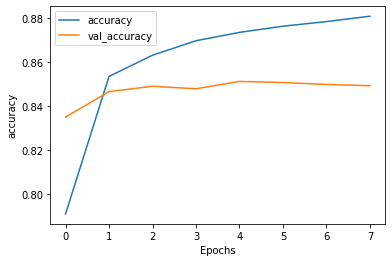

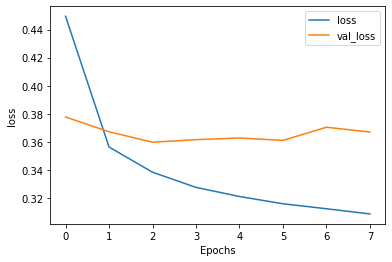

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
model.save('model.h5')

In [31]:
!pip install -q tensorflowjs

     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 40 kB 6.9 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 16.2 MB 56.4 MB/s 
     |████████████████████████████████| 197 kB 61.2 MB/s 
     |████████████████████████████████| 237 kB 80.6 MB/s 
     |████████████████████████████████| 8.3 MB 65.9 MB/s 
     |████████████████████████████████| 66 kB 5.1 MB/s 
     |████████████████████████████████| 154 kB 78.1 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
     |████████████████████████████████| 6.0 MB 58.4 MB/s 
     |████████████████████████████████| 1.7 MB 72.2 MB/s 
     |████████████████████████████████| 439 kB 74.0 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 


In [32]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2022-12-15 09:26:53.550786: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-15 09:26:53.551402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-15 09:26:53.551439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
